### 1. Importing and Setting-up

#### 1.1. Importing Libraries

In [1]:
# Importing the necessary libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams

#### 1.2. Setting up variables

In [2]:
# Configure some parameters
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18,8

#### 1.3. Loading Data

In [3]:
# Loading the data
df = sm.datasets.co2.load_pandas().data
df.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


### 2. Exploring the data

#### 2.1. Min and Max values

In [4]:
# Checking for the min and max values

minDate = df.index.min()
maxDate = df.index.max()

print(f'We have data starting from {minDate} until {maxDate}')

We have data starting from 1958-03-29 00:00:00 until 2001-12-29 00:00:00


#### 2.2. Length and index

In [5]:
# Checking the size of data
print(f'Length of data is {len(df)}')

Length of data is 2284


Thus, all in all we have data for almost 50 years.

Further, in case of time-series data, the dates should be used as an index. Since, we imported the data from statsmodels it is set, otherwise we can set it using df.set_index('date').

In [6]:
# Checking the index of the data
df.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

The dtype = datetime[ns] field confirms that our index is made of date stamp objects, while length = 2284 and freq = 'W-SAT' tells us that we have 2284 weekly date stamps starting on Saturdays.

Weekly data can be tricky to work with, so let’s use the monthly averages of our time-series instead. This can be obtained by using the convenient resample function, which allows us to group the time-series into buckets (1 month), apply a function on each group (mean), and combine the result (one row per group).

#### 2.3. Resampling to get monthly data

In [7]:
# Performing resampling of data from weekly to monthly
df = df['co2'].resample('MS').mean()
df[:5]

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

Here, the MS means that we group the data in buckets by months and ensures that we are using the start of each month as the timestamp.

In [8]:
# Verifying the data changed from weekly to monthly
df.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01',
               '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01',
               '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', length=526, freq='MS')

The dtype = datetime[ns] field confirms that our index is made of date stamp objects, while length = 526 and freq = 'MS' tells us that we have 525 monthly date stamps.

#### 2.4. Null values

In [9]:
# Checking for null values
df.isnull().sum()

5

This output tells us that there are 5 months with missing values in our time series.

In [10]:
# Filling na values
df = df.fillna(df.bfill())
df.isnull().sum()

0

Generally, we should 'fill in' missing values if they are not too numerous so that we don’t have gaps in the data using the fillna() command. For simplicity, we can fill in missing values with the closest non-null value in our time series, although it is important to note that a rolling mean would sometimes be preferable.

#### 2.5. Visualization

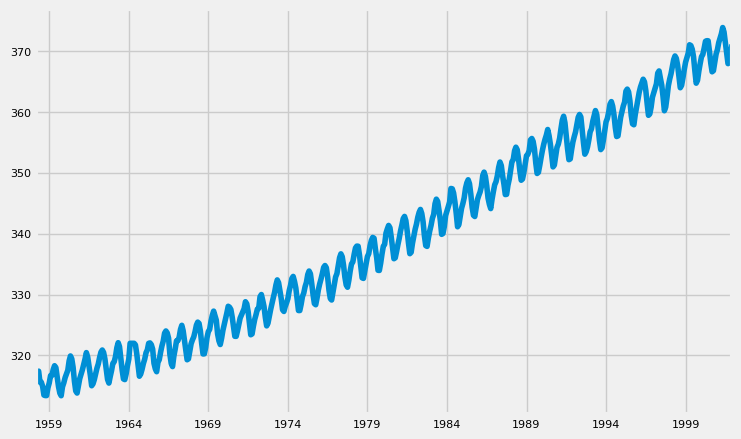

In [11]:
# Plotting the data
df.plot(figsize=(8, 5))
plt.show()

Generally, for time-series data, there is a distinguishable pattern that appears when we plot the data. Like for example for sals data, the sales are always low at the beginning of the year and high at the end of the year, thus giving an upward trend within any single year.

So, to understand the patterns, we visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

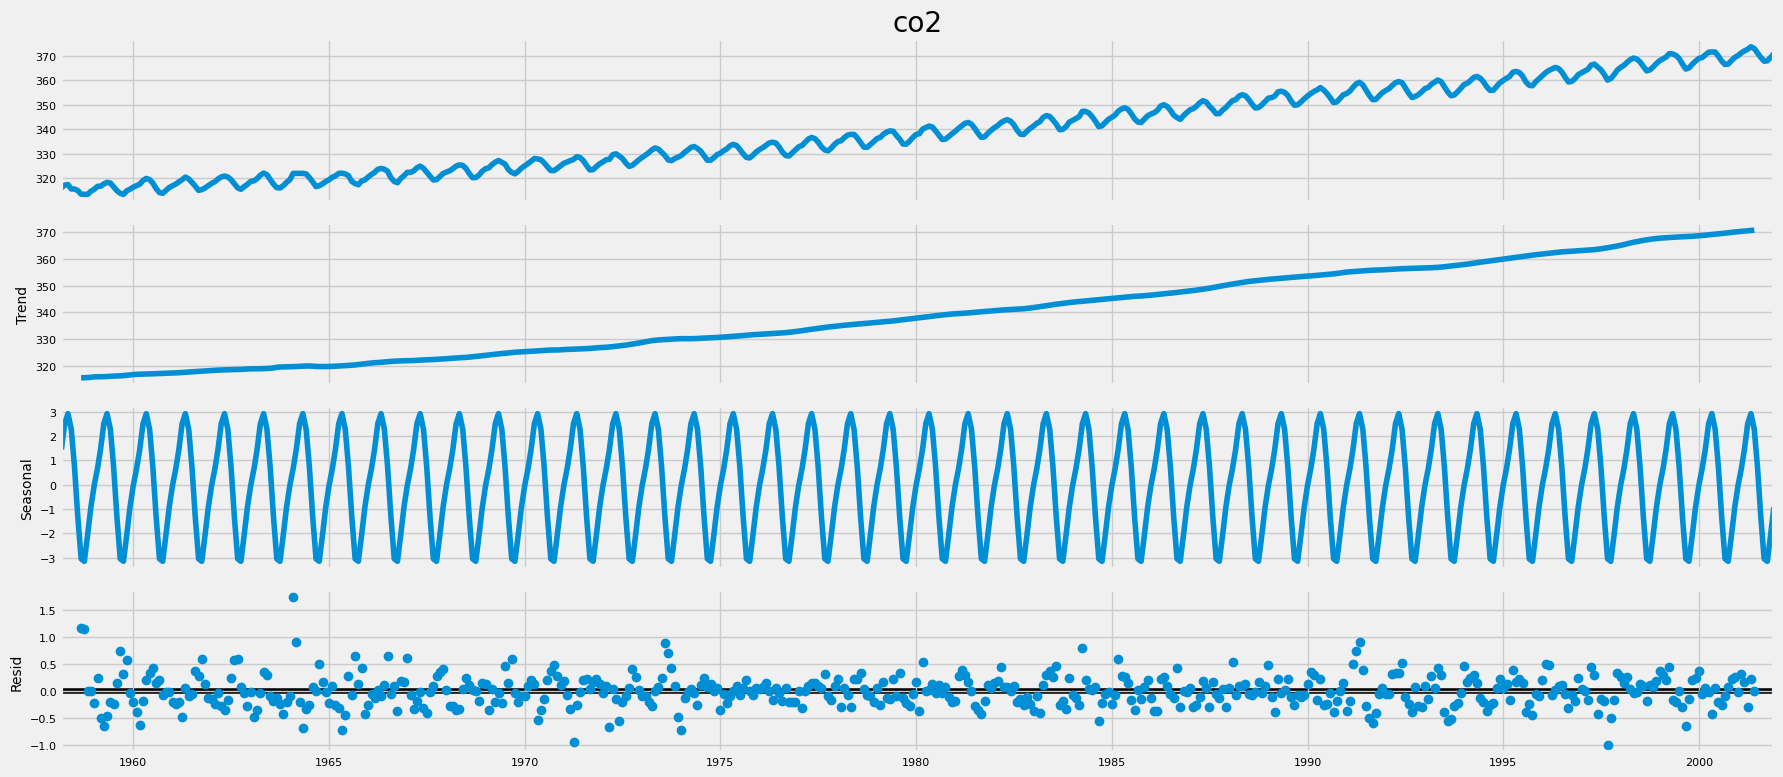

In [12]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the level of carbon dioxide is pretty stable.

### 3. Time Series Forecasting

ARIMA stands for Autoregressive Integrated Moving Average. The ARIMA models are denoted with the notation ARIMA(p, d, q), wherein the parameters represent seasonality, trend and noise in the data.

#### 3.1. Setting up ARIMA model

In [13]:
# Configuring the ARIMA model
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


Next step is to select the parameters for our carbon dioxide data. The intention here is to use a grid-search method to find the optimal set of parameters that yields the best performance for our model.

In [14]:
# Creating a grid-search for params
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343623902251
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:6027.256392993779
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411787
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172763899
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1480.7910932052632
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1414.0325743135852
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1049.1885509671274
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1000.6304768410106
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320058
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878432917653
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1027.99162305469
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897807282
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912915386
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:998.6335038183933
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1236.4167518145455
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1036.873199168639
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:1001.9764518181969
A

The above output suggests that SARIMAX(2, 0, 1)x(1, 0, 2, 12) yields the lowest AIC value of 271.77. Therefore we should consider this to be optimal option.

#### 3.2. Fitting the ARIMA model

In [15]:
# Fitting the ARIMA model to the optimal parameters found in the above step
mod = sm.tsa.statespace.SARIMAX(df,
                                order = (2, 0, 1),
                                seasonal_order = (1, 0, 2, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1361      0.093     12.250      0.000       0.954       1.318
ar.L2         -0.1501      0.092     -1.637      0.102      -0.330       0.030
ma.L1         -0.4842      0.082     -5.876      0.000      -0.646      -0.323
ar.S.L12       1.0042      0.000   5626.051      0.000       1.004       1.005
ma.S.L12      -1.0065      0.072    -13.999      0.000      -1.147      -0.866
ma.S.L24      -0.0513      0.052     -0.988      0.323      -0.153       0.050
sigma2         0.0829      0.005     15.190      0.000       0.072       0.094


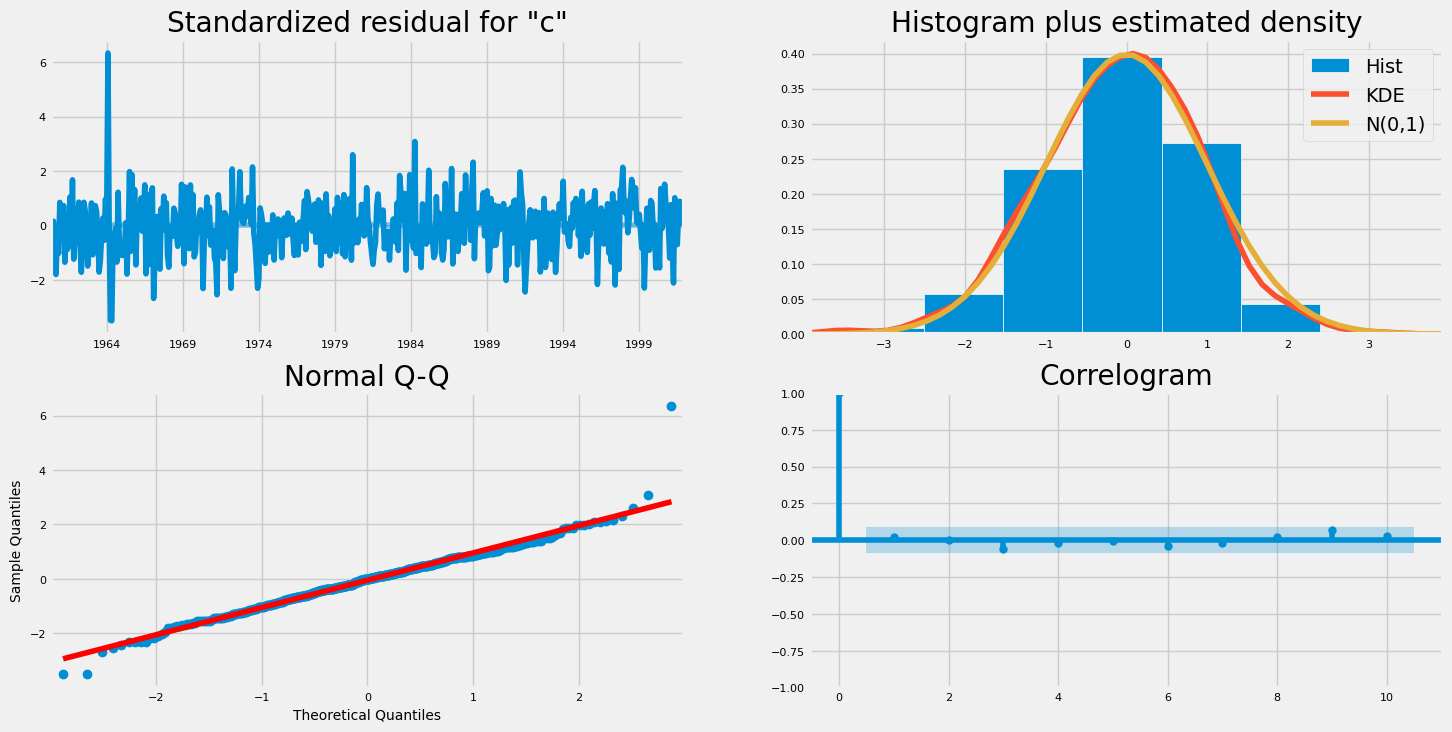

In [16]:
# Plotting the diagonstics to identify any unusual behaviour
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect since our model diagnostics suggests that the model residuals are unstable.

#### 3.3. Validating forecasts of ARIMA model

To help us understand the accuracy of our forecasts, we compare predicted sales to real co2 of the time series, and we set forecasts to start at 1997–01–01 to the end of the data.

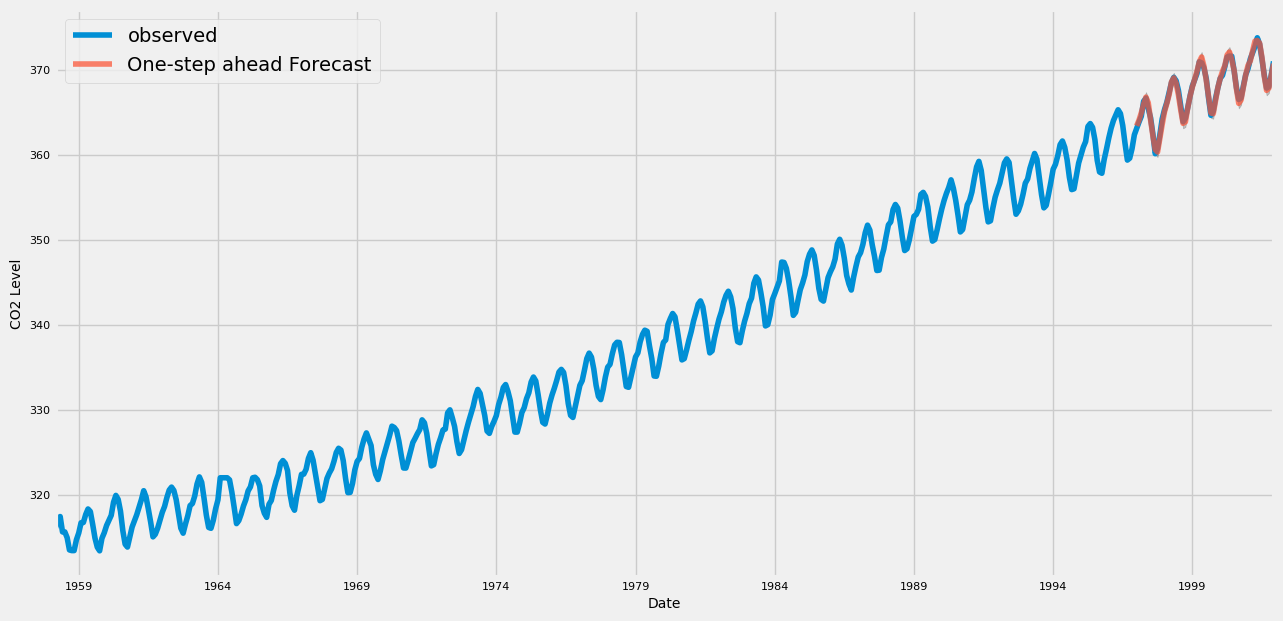

In [17]:
# Running model on validation data
pred = results.get_prediction(start = pd.to_datetime('1997-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = df['1958':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = .7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Level')
plt.legend()
plt.show()

In [18]:
df_forecasted = pred.predicted_mean
df_truth = df['1997-01-01':]
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}\n'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.1

The Root Mean Squared Error of our forecasts is 0.31


Well it is obvious that given the energy consumption trends followed by people, the CO2 levels are increasing. Since, the MSE and RMSE are very small, in my opinion, the time-series model can be said here in this case to be more than good.  

#### 3.4. Producing and Visualizing forecasts

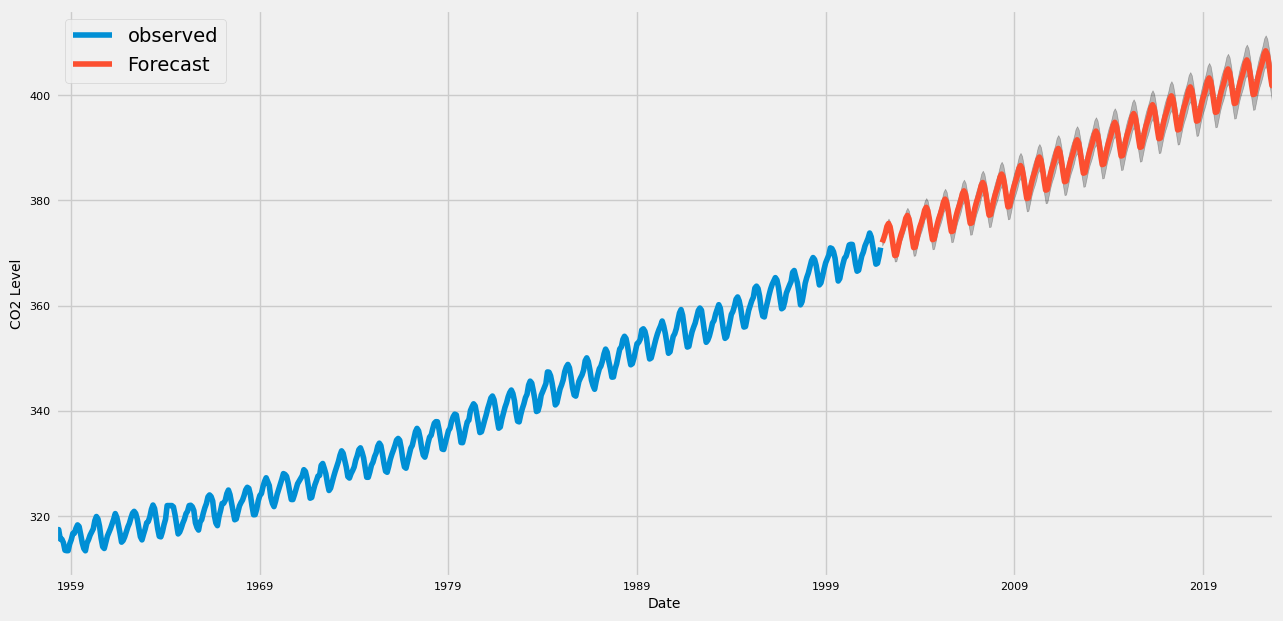

In [19]:
pred_uc = results.get_forecast(steps = 250)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Level')
plt.legend()
plt.show()

Our model clearly captured CO2 trends. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.